# Base methods to deal with the test cases

In [94]:
import matplotlib.pyplot as plt  
%matplotlib inline
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

### Base methods to deal with preprocessing data
- **fill_gaps** : *Method that deals with missing data from a dataframe*
- **normalize** : *Method that normalize data rescaling numerical values to a predefined range*
- **pca** : *Method that applies pca in a dataframe*

In [118]:
def fill_gaps(df, empty_token = '?'):
    imputer = SimpleImputer(missing_values = empty_token, strategy = 'most_frequent')
    result = imputer.fit_transform(df)
    
    result_df = DataFrame(result)
    result_df.columns = df.columns
    result_df.index = df.index
    return result_df

def normalize(df, columns, range=(0,1)):
    scaler = MinMaxScaler(feature_range=range)
    for col in columns:
        scaled_values = scaler.fit_transform(df[[col]].values.astype(float))
        df[col] = scaled_values
    return df

def pca(df, components = 70):
    pca = PCA(n_components = components)
    pca_values = pca.fit_transform(df)
    component_cols = []
    for i in range(0, components):
        component_cols.append('component_%s'%i)
    return DataFrame(data = pca_values, columns = component_cols)

def cost(fp, fn):
    return (fp * 500) + (fn*10)

def train_cluster(pre_train_df, pre_test_df):
    x_train = pre_train_df.iloc[:, 1:].values
#     y_train = pre_train_df['class'].values

    x_test = pre_test_df.iloc[:, 1:].values
    y_test = pre_test_df['class'].values
    
    kmeans = KMeans(n_clusters=2)  
    kmeans.fit(x_train)

#     display("Clusters labels: %s" % (kmeans.labels_))
#     display("Clusters centers: %s" % (kmeans.cluster_centers_))
    plt.figure(figsize=(8,6))
    plt.scatter(x_train[:,0],x_train[:,1], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'green', label = 'Centroids')
    
    y_pred = kmeans.predict(x_test)
    y_pred = np.where(y_pred > 0, 'pos', 'neg')
          
    accuracy = accuracy_score(y_test, y_pred)
    display("Accuracy %s" % (accuracy))
    
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    display ("False positives: %s - False Negatives %s" % (fp, fn))
    display("Cost: %s" % (cost(fp, fn)))

    confusion_mtx = confusion_matrix(y_pred, y_test) 
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_mtx, annot=True, fmt="d");
    

# Load the train and test datasets

In [106]:
train_df = pd.read_csv("aps_training_set_sample3.csv")
test_df = pd.read_csv("aps_failure_test_set.csv")

# Balancing classes in train dataset

In [119]:
# we need to balance the classes 
positive_class = train_df[train_df['class'] == 'pos']
qtd_pos = positive_class.shape[0]
negative_class = train_df[train_df['class'] == 'neg']
qtd_neg = negative_class.shape[0]

display("Positive samples: %s - Negative samples: %s" %(qtd_pos, qtd_neg))
new_samples = min(qtd_neg, qtd_pos)
display("Using %s samples per class" % (new_samples))


train_df = pd.concat([positive_class[:new_samples], negative_class[:new_samples]], ignore_index = True)
display(train_df['class'].value_counts())
train_df.shape

'Positive samples: 1000 - Negative samples: 1000'

'Using 1000 samples per class'

pos    1000
neg    1000
Name: class, dtype: int64

(2000, 171)

# Test Case 1
- fill_gaps
- Using DecisionTreeClassifier from sklearn

pos    1000
neg    1000
Name: class, dtype: int64

'Accuracy 0.8185'

'False positives: 373 - False Negatives 2531'

'Cost: 211810'

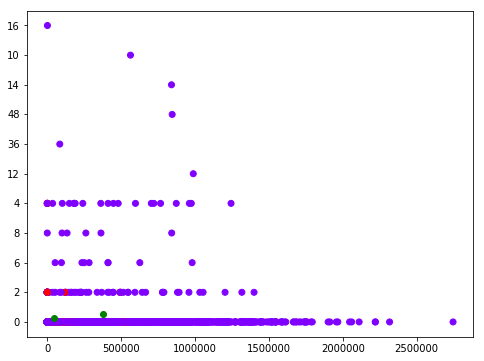

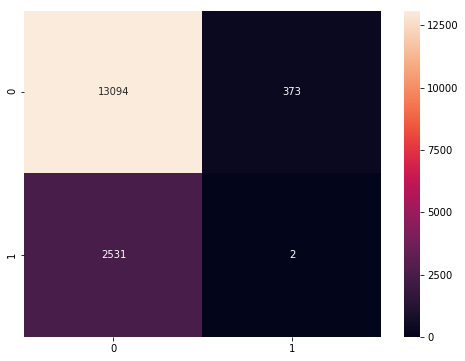

In [120]:
pre_train_df = fill_gaps(train_df)
pre_test_df = fill_gaps(test_df)

display(pre_train_df['class'].value_counts())

train_cluster(pre_train_df, pre_test_df)

# Test Case 2
- fill_gaps
- normalizing top 10 std_dev columns

ac_000    5.943633e+08
dq_000    2.818990e+08
eb_000    1.113884e+08
bb_000    3.246790e+07
bv_000    3.235481e+07
cq_000    3.235481e+07
bu_000    3.235481e+07
bx_000    3.090717e+07
cc_000    2.912746e+07
du_000    2.895663e+07
dtype: float64

'Accuracy 0.978375'

'False positives: 143 - False Negatives 203'

'Cost: 73530'

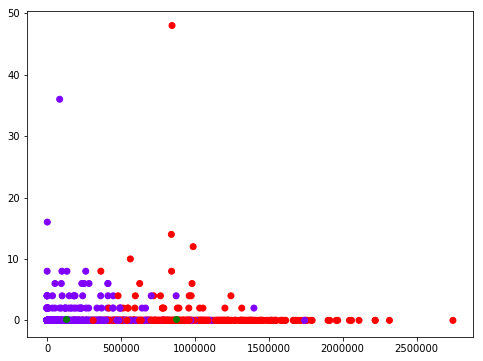

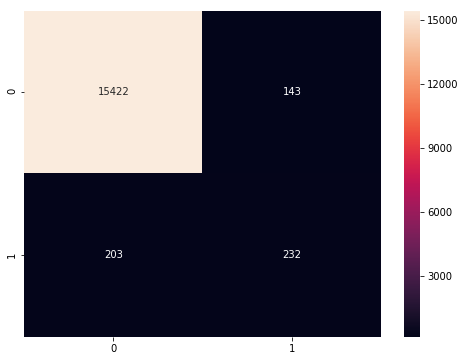

In [121]:
pre_train_df = fill_gaps(train_df)
# Ignoring first column that is the label
for c in pre_train_df.columns[1:].values:
    pre_train_df[c] = pd.to_numeric(pre_train_df[c])
    
std_df = pre_train_df.std(axis = 0, skipna=True)
top10_std = std_df.sort_values(ascending=[False])[:10]
display(top10_std)
top10_std_columns = top10_std.index
pre_train_df = normalize(pre_train_df, columns = top10_std_columns)

pre_test_df = fill_gaps(test_df)
pre_test_df = normalize(pre_test_df, columns = top10_std_columns)

train_cluster(pre_train_df, pre_test_df)

# Test Case 3
- fill gaps
- normalizing top 10 std_dev columns
- dimensionality reduction through pca

'Accuracy 0.0400625'

'False positives: 336 - False Negatives 15023'

'Cost: 318230'

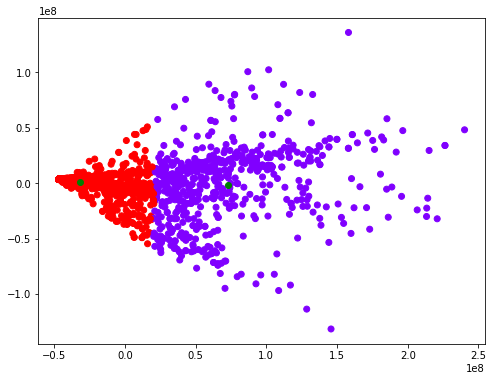

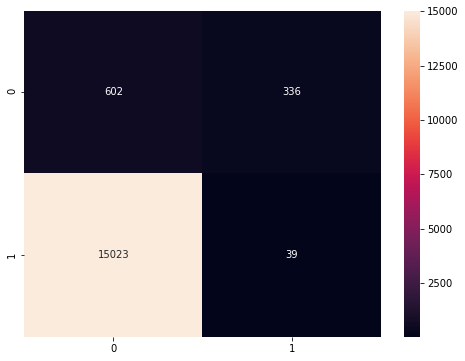

In [122]:
pca_train_df = pca(pre_train_df.loc[:, pre_train_df.columns != 'class'])
pca_test_df = pca(pre_test_df.loc[:, pre_train_df.columns != 'class'])

pca_train_df = pd.concat([pre_train_df['class'], pca_train_df], axis=1)
pca_test_df = pd.concat([pre_test_df['class'], pca_test_df], axis = 1)

train_cluster(pca_train_df, pca_test_df)